<a href="https://colab.research.google.com/github/Hamrita/Colloque_2025/blob/main/LSTM_colloque.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


In [6]:
import pandas as pd

In [7]:
# import data
url="https://raw.githubusercontent.com/Hamrita/Colloque_2025/refs/heads/main/BTC.csv"
df=pd.read_csv(url)
BTC=df.iloc[:,1].values.astype('float32')
BTC=BTC.reshape(BTC.shape[0],1)

In [8]:
# Split into train and test sets
train_size = int(len(BTC) * 0.9)
test_size = len(BTC) - train_size
train, test = BTC[0:train_size], BTC[train_size:len(BTC)]

In [9]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)

In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  #get look_back sequences
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) #get the target after look_back sequences
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 10  # Sequence length (tunable)
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

In [12]:
print(trainX.shape)
print(trainY.shape)

(2989, 10, 1)
(2989,)


In [20]:
def build_model1(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=128,step=32),return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2])))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.6,step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate),metrics = ['mse'])
    return model


In [21]:
tuner= kt.RandomSearch(
        build_model1,
        objective='mse',
        max_trials=10,
        executions_per_trial=1
        )

# Early stopping callback
early_stopper = EarlyStopping(
    monitor='mse',
    min_delta=0.01,
    patience=5,
    restore_best_weights=True
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
tuner.search(
        x=trainX,
        y=trainY,
        epochs=10,
        batch_size=128,
        validation_data=(testX,testY),
)

Trial 10 Complete [00h 01m 50s]
mse: 0.0012970971874892712

Best mse So Far: 0.0009401499992236495
Total elapsed time: 00h 13m 02s


In [23]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'input_unit': 96,
 'n_layers': 1,
 'lstm_0_units': 96,
 'layer_2_neurons': 256,
 'Dropout_rate': 0.1,
 'dense_activation': 'relu',
 'learning_rate': 0.00030094925731594785,
 'lstm_1_units': 32,
 'lstm_2_units': 64}

In [25]:
fit_model=best_model.fit(trainX,trainY,epochs=200,verbose=0)
fit_tr=best_model.predict(trainX)
fit_te=best_model.predict(testX)
tr_fit=scaler.inverse_transform(fit_tr)
Pred=scaler.inverse_transform(fit_te)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [52]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
   return sqrt(mean_squared_error(actual, predicted))

def measure_mape(actual, predicted):
   return np.mean(np.abs((actual - predicted) / actual)) * 100
test_y=scaler.inverse_transform(testY.reshape(-1,1))
train_y=scaler.inverse_transform(trainY.reshape(-1,1))
print(measure_rmse(test_y, Pred))
print(measure_rmse(train_y, fit_tr))

3860.9015786471427
24810.61321289742


In [48]:
print(Pred.shape)
print(test[11:].shape)

(323, 1)
(323, 1)


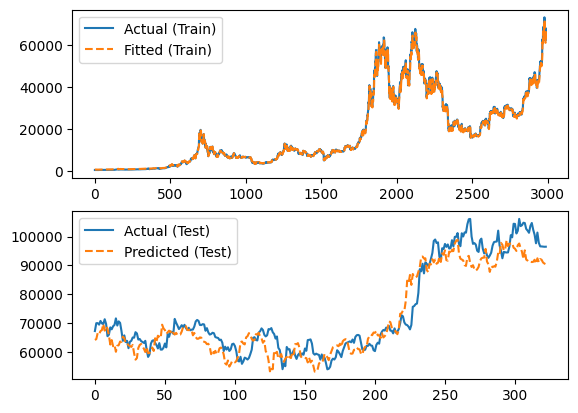

In [58]:
fig, axs = plt.subplots(2)
axs[0].plot(train_y,label='Actual (Train)')
axs[0].plot(tr_fit, linestyle="dashed", label='Fitted (Train)')
axs[0].legend()
axs[1].plot(test[11:],label='Actual (Test)')
axs[1].plot(Pred,linestyle="dashed",label='Predicted (Test)')
axs[1].legend()
plt.show()

In [60]:
best_model.evaluate(test[11:], Pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4445843968.0000 - mse: 4445843968.0000 


array([73134.94464345, 73134.94464345])

In [53]:
measure_rmse(test[11:],Pred), measure_mape(test[11:],Pred)

(4298.384347635749, 4.170934110879898)

In [56]:
measure_rmse(train_y,tr_fit), measure_mape(train_y,tr_fit)

(968.2927630629075, 7.210668921470642)

In [61]:
pred=pd.DataFrame(Pred)
y_test=pd.DataFrame(test[11:])
pred.to_csv('pred.csv', index=False)
y_test.to_csv('y_test.csv', index=False)